Epoch 1/5
219/219 [==============================] - 49s 200ms/step - loss: 0.6096 - accuracy: 0.8487 - precision_7: 0.8487 - recall_7: 0.8487 - F1Score: 0.8493 - val_loss: 0.2363 - val_accuracy: 0.9129 - val_precision_7: 0.9129 - val_recall_7: 0.9129 - val_F1Score: 0.9121
Epoch 2/5
219/219 [==============================] - 40s 182ms/step - loss: 0.0706 - accuracy: 0.9875 - precision_7: 0.9875 - recall_7: 0.9875 - F1Score: 0.9876 - val_loss: 0.0604 - val_accuracy: 0.9834 - val_precision_7: 0.9834 - val_recall_7: 0.9834 - val_F1Score: 0.9825
Epoch 3/5
219/219 [==============================] - 40s 184ms/step - loss: 0.0339 - accuracy: 0.9934 - precision_7: 0.9934 - recall_7: 0.9934 - F1Score: 0.9934 - val_loss: 0.0097 - val_accuracy: 0.9971 - val_precision_7: 0.9971 - val_recall_7: 0.9971 - val_F1Score: 0.9972
Epoch 4/5
219/219 [==============================] - 40s 185ms/step - loss: 0.0193 - accuracy: 0.9971 - precision_7: 0.9971 - recall_7: 0.9971 - F1Score: 0.9971 - val_loss: 0.571

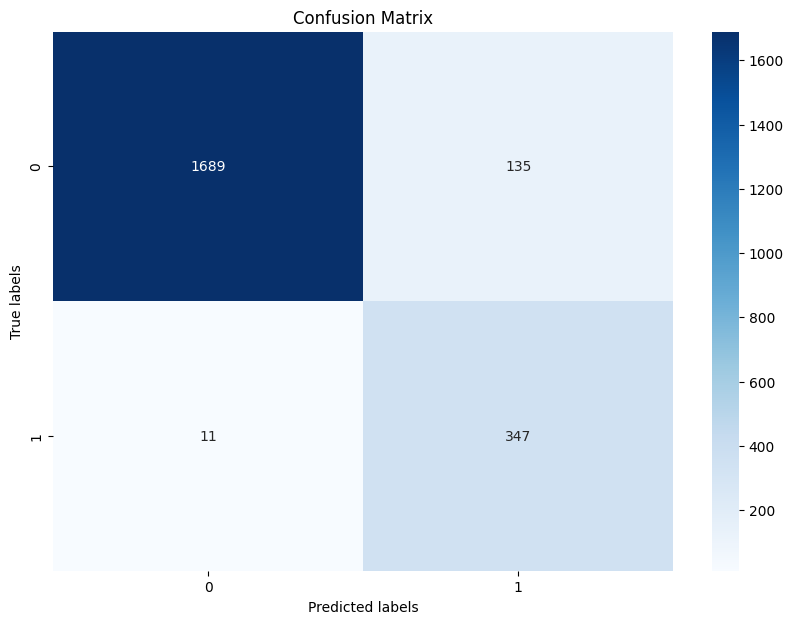

In [8]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns

# Mount Google Drive (specific to Google Colab)
# from google.colab import drive
# drive.mount('/content/gdrive')
# data = pd.read_csv('/content/gdrive/MyDrive/RoadSense/01_tracks-2.csv')

tracks1 = pd.read_csv('01_tracks.csv')
tracks2 = pd.read_csv('02_tracks.csv')
tracks3 = pd.read_csv('03_tracks.csv')
tracks4 = pd.read_csv('04_tracks.csv')
tracks5 = pd.read_csv('05_tracks.csv')
tracks6 = pd.read_csv('01_tracks.csv')
tracks7 = pd.read_csv('02_tracks.csv')
tracks8 = pd.read_csv('03_tracks.csv')
tracks9 = pd.read_csv('04_tracks.csv')
tracks10 = pd.read_csv('05_tracks.csv')

lista = []
lista.append(tracks1)
lista.append(tracks2)
lista.append(tracks3)
lista.append(tracks4)
lista.append(tracks5)
lista.append(tracks6)
lista.append(tracks7)
lista.append(tracks8)
lista.append(tracks9)
lista.append(tracks10)

eltolas = 0
for df in lista:
  df['id'] = df['id'] + eltolas
  eltolas += df['id'].nunique()

data = pd.concat([tracks1, tracks2, tracks3, tracks4, tracks5, tracks6,tracks7,tracks8,tracks9,tracks10], ignore_index=True)


def get_lane_changed_ID(data):
    changedID = []
    unique_ids = data['id'].unique()

    for unique_id in unique_ids:
        vehicle = data[data["id"] == unique_id]
        unique_lane_ids = vehicle['laneId'].unique()
        
        if len(unique_lane_ids) > 1:
            changedID.append(unique_id)
            
    return changedID

def lanechange_column_add(data):
    data['lane_change'] = 0
    data.loc[data['id'].isin(get_lane_changed_ID(data)), 'lane_change'] = 1
    return data

# data = combined_data = pd.concat([lanechange_column_add(tracks1), lanechange_column_add(tracks2), lanechange_column_add(tracks3), lanechange_column_add(tracks4), lanechange_column_add(tracks5)], ignore_index=True)
data = lanechange_column_add(data)

columns_to_drop = [
    'frontSightDistance', 'backSightDistance', 'dhw', 'thw', 'ttc',
    'precedingXVelocity', 'precedingId', 'followingId', 'leftPrecedingId',
    'leftAlongsideId', 'leftFollowingId', 'rightPrecedingId', 'rightAlongsideId',
    'rightFollowingId', 'laneId', 'width', 'height', 'frame'
]
data = data.drop(columns_to_drop, axis=1)

grouped = data.groupby('id')
sequences = [group.drop('id', axis=1).values for _, group in grouped]

max_sequence_length = max(len(s) for s in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', dtype='float32')

# Convert labels to one-hot encoded format
labels = np.array([group['lane_change'].iloc[0] for _, group in grouped])
one_hot_labels = to_categorical(labels, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(max_sequence_length, padded_sequences.shape[2]), dropout=0.2)),
    Bidirectional(tf.keras.layers.LSTM(30, dropout=0.2)),
    tf.keras.layers.Dense(2, activation='softmax')
])

def F1Score(y_true, y_pred):
    # Calculating Precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    # Calculating Recall
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    # Calculating F1 Score
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score])

class_weights = {0: 1, 1: 3}

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, class_weight=class_weights)

loss, accuracy, precision, recall, f1_score = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Recall: {recall*100:.2f}%")
print(f"Test F1 Score: {f1_score:.4f}")

f1_score = F1Score(y_test, model.predict(X_test))
print(f"Test F1 Score: {f1_score:.4f}")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()